<a href="https://colab.research.google.com/github/Kimhantag/Posco_AIBigdata_Academy25_edu/blob/main/6.RNN_blank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import random
import re

import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
top_words = 10000
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=top_words) #  데이터로드에 정해진 parameter로서, 할당된 크기만큼 자주쓰인 단어를 불러옴

print(x_train.shape) # list가 총 25,000개 있음, 이 리뷰안에 여러 단어가 쓰였을텐데 위에서 언급한 10000개의 단어만 사용하게 됩니다.
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)  # 0과 1이 있다. 0의 경우 부정 , 1의 경우 긍정
print(y_test[0]) # 0 이 나온 것으로 미루어 부정적인 리뷰

17464789/17464789 [==============================] - 0s 0us/step
(25000,)
(25000,)
(25000,)
(25000,)
0


1641221/1641221 [==============================] - 0s 0us/step
the
and
a
of
to
direct
[Example] lengths of 5 reviews:  [218, 189, 141, 550, 147]
The longest length of the review : 2494
The average length of the review : 238.71364


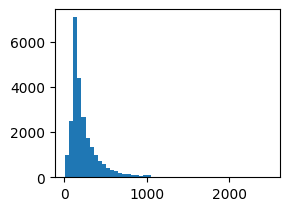

In [ ]:
word_to_index = tf.keras.datasets.imdb.get_word_index()

index_to_word ={}
for key, value in word_to_index.items():    # dictionary 를 tuple들로 만들기
    index_to_word[value + 3] = key          # value+3가 단어가 사용된 순위, key가 단어입니다. +3을 해주는 이유는 0,1,2가 special로 설정되었기 때문에, 3이 제일 많이 나온 단어이기 때문입니다.

for i in range(5) :
    print(index_to_word[i + 4])  ## 제일 많이 나온 단어 5개  / 다섯번째를 불러오는게 아니라 키 값에 맞는 value를 불러오는 것임.

print(index_to_word[1504]) # 1500번째로 잘 많이 나온 단어

len_result = [len(s) for s in x_train] # 길이의 값을 list로 만듦
print('[Example] lengths of 5 reviews: ', len_result[:5])
print('The longest length of the review : {}'.format(np.max(len_result)))
print('The average length of the review : {}'.format(np.mean(len_result)))

plt.subplot(2,2,2)
plt.hist(len_result, bins=50)
plt.show()

In [ ]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")): # pad 패드토큰=단어 | sos 시작을 알리는 토큰 | unk 주어진 단어가 미확인이라고 하는 토큰
    index_to_word[index]=token
print(x_train[2])
print(' '.join([index_to_word[index] for index in x_train[2]]))
print(y_train[2]) # 어떤 리뷰인지 맞춰보기 0은 부정 1은 긍정

[1, 14, 47, 8, 30, 31, 7, 4, 249, 108, 7, 4, 5974, 54, 61, 369, 13, 71, 149, 14, 22, 112, 4, 2401, 311, 12, 16, 3711, 33, 75, 43, 1829, 296, 4, 86, 320, 35, 534, 19, 263, 4821, 1301, 4, 1873, 33, 89, 78, 12, 66, 16, 4, 360, 7, 4, 58, 316, 334, 11, 4, 1716, 43, 645, 662, 8, 257, 85, 1200, 42, 1228, 2578, 83, 68, 3912, 15, 36, 165, 1539, 278, 36, 69, 2, 780, 8, 106, 14, 6905, 1338, 18, 6, 22, 12, 215, 28, 610, 40, 6, 87, 326, 23, 2300, 21, 23, 22, 12, 272, 40, 57, 31, 11, 4, 22, 47, 6, 2307, 51, 9, 170, 23, 595, 116, 595, 1352, 13, 191, 79, 638, 89, 2, 14, 9, 8, 106, 607, 624, 35, 534, 6, 227, 7, 129, 113]
<sos> this has to be one of the worst films of the 1990s when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touching the floor at how bad it really was the rest of the time everyone else in the theatre just started talking to each other leaving or generally crying into their popcorn that they actu

In [ ]:
# truncate and pad input sequences with .preprocessing.sequence.pad_sequences
max_len = 200  # 이 길이보다 sequence의 길이가 자르면 잘라낼 것이고, 짧다면 의미없는 값을 집어넣어(padding 과정:0으로 집어넣음) sequence의 길이를 200으로 맞추어 줍니다.
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=200) # 200보다 짧을 경우 0으로 padding하는 코드
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=200)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode ='min', verbose = 1, patience=3)
mc1 = tf.keras.callbacks.ModelCheckpoint('./rnn_imdb', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)
mc2 = tf.keras.callbacks.ModelCheckpoint('./lstm_imdb', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)
mc3 = tf.keras.callbacks.ModelCheckpoint('./multi_imdb', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [ ]:
rnn = tf.keras.Sequential()
# (1, 255, 1999 ~~~) 단어를 숫자로 매핑 1~10000
rnn.add(layers.Embedding(top_words, 160)) # 1 -> R^160 각각의 인덱스로 표현된 단어들을 벡터로 표현
# [batch_size, 200, 1] -> [batch_size, 200, 160]
# x:input, h:hidden | h_new = xw_x + hw_h + b | b -> 64dim | w_x -> 160*64 dim | w_h -> 64*64 dim
rnn.add(layers.SimpleRNN(64)) # -> 64:hidden states dimension
rnn.add(layers.Dense(1, activation = 'sigmoid'))
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 160)         1600000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                14400     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1614465 (6.16 MB)
Trainable params: 1614465 (6.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
rnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
result = rnn.fit(x_train, y_train, epochs = 5, callbacks=[es, mc1], batch_size = 64,
                 validation_split = 0.2)

Epoch 1/5
358/358 [==============================] - ETA: 0s - loss: 0.5436 - accuracy: 0.7085
Epoch 1: val_accuracy improved from -inf to 0.81060, saving model to ./rnn_imdb
358/358 [==============================] - 45s 120ms/step - loss: 0.5436 - accuracy: 0.7085 - val_loss: 0.4404 - val_accuracy: 0.8106
Epoch 2/5
358/358 [==============================] - ETA: 0s - loss: 0.3309 - accuracy: 0.8636
Epoch 2: val_accuracy improved from 0.81060 to 0.84620, saving model to ./rnn_imdb
358/358 [==============================] - 39s 108ms/step - loss: 0.3309 - accuracy: 0.8636 - val_loss: 0.4062 - val_accuracy: 0.8462
Epoch 3/5
358/358 [==============================] - ETA: 0s - loss: 0.2330 - accuracy: 0.9080
Epoch 3: val_accuracy did not improve from 0.84620
358/358 [==============================] - 38s 107ms/step - loss: 0.2330 - accuracy: 0.9080 - val_loss: 0.4698 - val_accuracy: 0.8322
Epoch 4/5
358/358 [==============================] - ETA: 0s - loss: 0.1204 - accuracy: 0.9584
Epoc

In [ ]:
rnn.evaluate(x_test, y_test)

782/782 [==============================] - 13s 17ms/step - loss: 0.7138 - accuracy: 0.7802


[0.7138184309005737, 0.7801600098609924]

In [ ]:
loaded_model = tf.keras.models.load_model('rnn_imdb')
print((loaded_model.evaluate(x_test, y_test)))

782/782 [==============================] - 14s 17ms/step - loss: 0.4198 - accuracy: 0.8409
[0.4197905957698822, 0.8409199714660645]


In [ ]:
def sentiment_predict(new_sentence):
    # 알파벳과 숫자를 제외하고 모두 제거 및 알파벳 소문자화
    new_sentence = re.sub('[^0-9a-zA-Z ]', '', new_sentence).lower()

    # 정수 인코딩
    encoded = []
    for word in new_sentence.split():
        # 단어 집합의 크기를 10,000으로 제한.
        try :
            if word_to_index[word] <= 10000:
                encoded.append(word_to_index[word]+3)
            else:
                # 10,000 이상의 숫자는 <unk> 토큰으로 취급.
                encoded.append(2)
        # 단어 집합에 없는 단어는 <unk> 토큰으로 취급.
        except KeyError:
            encoded.append(2)

    pad_new = tf.keras.preprocessing.sequence.pad_sequences([encoded], maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("positive with the probability {:.2f}% .".format(score * 100))
    else:
        print("negative with the probability {:.2f}% ".format((1 - score) * 100))

In [ ]:
My_review = "hi this movie is the amazing movie i have ever seen in my life. really intersting very fun. This was what I thought before the end of the movie. The last scene was really disgusting"
sentiment_predict(My_review)

1/1 [==============================] - 0s 195ms/step
negative with the probability 91.14% 


<ipython-input-13-0be091181bb0>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


In [ ]:
lstm = tf.keras.Sequential()
lstm.add(layers.Embedding(top_words, 160))
lstm.add(layers.LSTM(64))
lstm.add(layers.Dense(2, activation='softmax'))
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 160)         1600000   
                                                                 
 lstm_1 (LSTM)               (None, 64)                57600     
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 1657730 (6.32 MB)
Trainable params: 1657730 (6.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
lstm.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics =['accuracy'])
print("Train LSTM Model With ")

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 1, stratify = y_train)

lstm.fit(x_train, y_train, epochs=5, callbacks = [es,mc2], batch_size= 60, validation_data=(x_val, y_val) )

Train LSTM Model With 
Epoch 1/5
334/334 [==============================] - ETA: 0s - loss: 0.4209 - accuracy: 0.8019
Epoch 1: val_accuracy improved from -inf to 0.87100, saving model to ./lstm_imdb
334/334 [==============================] - 149s 441ms/step - loss: 0.4209 - accuracy: 0.8019 - val_loss: 0.3158 - val_accuracy: 0.8710
Epoch 2/5
334/334 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.9077
Epoch 2: val_accuracy did not improve from 0.87100
334/334 [==============================] - 138s 412ms/step - loss: 0.2375 - accuracy: 0.9077 - val_loss: 0.3551 - val_accuracy: 0.8640
Epoch 3/5
334/334 [==============================] - ETA: 0s - loss: 0.1636 - accuracy: 0.9396
Epoch 3: val_accuracy did not improve from 0.87100
334/334 [==============================] - 100s 299ms/step - loss: 0.1636 - accuracy: 0.9396 - val_loss: 0.3988 - val_accuracy: 0.8622
Epoch 4/5
334/334 [==============================] - ETA: 0s - loss: 0.1108 - accuracy: 0.9614
Epoch 4: 

In [ ]:
rnn.evaluate(x_test,y_test)

782/782 [==============================] - 15s 19ms/step - loss: 0.7138 - accuracy: 0.7802


[0.7138184309005737, 0.7801600098609924]

In [ ]:
loaded_model2 = tf.keras.models.load_model('lstm_imdb')
print((loaded_model2.evaluate(x_test, y_test)))

782/782 [==============================] - 34s 43ms/step - loss: 0.3263 - accuracy: 0.8614
[0.3262588381767273, 0.8613600134849548]


In [ ]:
multi_lstm = tf.keras.Sequential()
multi_lstm.add(layers.Embedding(top_words, 160))
multi_lstm.add(layers.LSTM(64, return_sequences = True))
multi_lstm.add(layers.LSTM(64))
multi_lstm.add(layers.Dense(2, activation = 'softmax'))

multi_lstm.complie(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

print("Train Multi_LSTM")
multi_lstm.fit(x_train, y_train, epochs=5, callbacks=[es, mc2], batch_size=60, validation_data=(x_val, y_val) )

Train Multi_LSTM


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.